## Workshop Week 5

The goal of the workshop this week is to work through a standard Data Science workflow: exploring data, building models, making predictions, evaluating results.    We will do this in the first instance using a simple linear least squares model and will look at two datasets.  The first is the standard Iris dataset describing flowers, the second is the AutoMPG dataset. 



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

The datasets we will use are available in a number of forms.  We'll use the versions bundled with the __seaborn__ plotting library since they load as Pandas dataframes.  


In [2]:
iris = sns.load_dataset('iris')
print(iris.head())

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


## Explore the dataset

Examine the data, what are the columns? How is the spread of variables - eg. is it normally distributed?  You might want to use the [sns.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function which shows all variables plotted against each other as a matrix.  You should also look at the means and variances of each variable.  Get to know the Pandas methods (e.g. the `describe` method) for doing this.

Your goal is to get a good feel for the data you are dealing with. Eventually you will be trying to work out what techniques you might be able to use to work with the data. For now, just get used to exploring it.

In [3]:
# shape of dataframe

iris.shape

(150, 5)

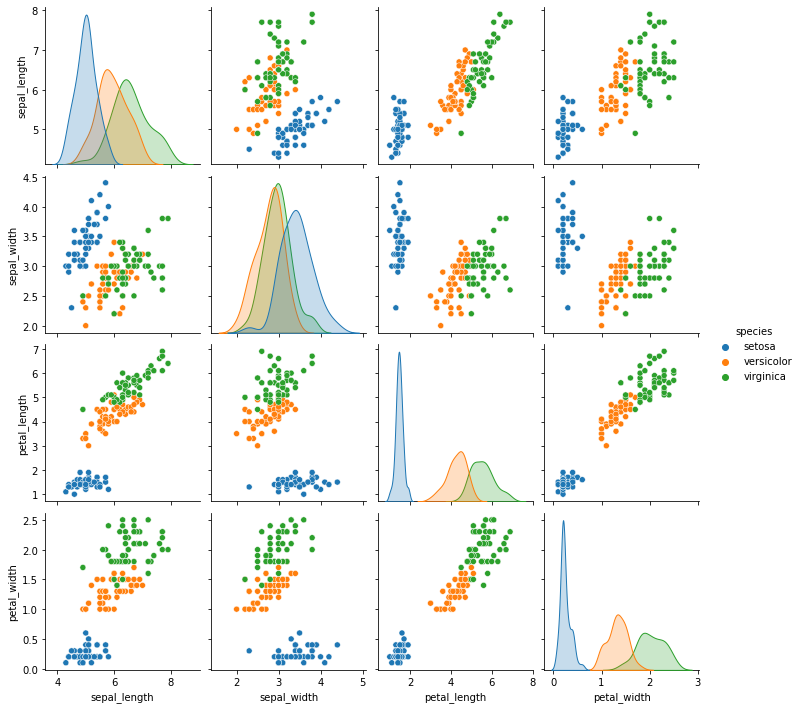

In [4]:
# show variables in pairplot

sns.pairplot(iris, hue='species')

In [5]:
# show correlations 

iris.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


In [6]:
# summary statistics

iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
# create species dataframes 

setosa = iris[iris["species"] == "setosa"]
versicolor = iris[iris["species"] == "versicolor"]
virginica = iris[iris["species"] == "virginica"]
setosa.shape, versicolor.shape, virginica.shape

((50, 5), (50, 5), (50, 5))

In [8]:
# show summary statistics for species

def summary(pre, s):
    print("{:<25} || Mean: {:.2f}, Median: {:.2f}, Min: {:.2f}, Max: {:.2f}".format(pre, s.mean(), s.median(), s.min(), s.max()))
    
summary("Sepal length setosa", setosa["sepal_length"])
summary("Sepal width setosa", setosa["sepal_width"])
summary("Petal length setosa", setosa["petal_length"])
summary("Petal width setosa", setosa["petal_width"])

summary("Sepal length versicolor", versicolor["sepal_length"])
summary("Sepal width versicolor", versicolor["sepal_width"])
summary("Petal length versicolor", versicolor["petal_length"])
summary("Petal width versicolor", versicolor["petal_width"])

summary("Sepal length virginica", virginica["sepal_length"])
summary("Sepal width virginica", virginica["sepal_width"])
summary("Petal length virginica", virginica["petal_length"])
summary("Petal width virginica", virginica["petal_width"])


Sepal length setosa       || Mean: 5.01, Median: 5.00, Min: 4.30, Max: 5.80
Sepal width setosa        || Mean: 3.43, Median: 3.40, Min: 2.30, Max: 4.40
Petal length setosa       || Mean: 1.46, Median: 1.50, Min: 1.00, Max: 1.90
Petal width setosa        || Mean: 0.25, Median: 0.20, Min: 0.10, Max: 0.60
Sepal length versicolor   || Mean: 5.94, Median: 5.90, Min: 4.90, Max: 7.00
Sepal width versicolor    || Mean: 2.77, Median: 2.80, Min: 2.00, Max: 3.40
Petal length versicolor   || Mean: 4.26, Median: 4.35, Min: 3.00, Max: 5.10
Petal width versicolor    || Mean: 1.33, Median: 1.30, Min: 1.00, Max: 1.80
Sepal length virginica    || Mean: 6.59, Median: 6.50, Min: 4.90, Max: 7.90
Sepal width virginica     || Mean: 2.97, Median: 3.00, Min: 2.20, Max: 3.80
Petal length virginica    || Mean: 5.55, Median: 5.55, Min: 4.50, Max: 6.90
Petal width virginica     || Mean: 2.03, Median: 2.00, Min: 1.40, Max: 2.50


## Linear Regression

A quick search will reveal many different ways to do linear regression in Python. We will use the [sklearn LinearRegression](http://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) function.  The sklearn module has many standard machine learning methods so it is a good one to get used to working with.  

Linear Regression involves fitting a model of the form:

> $y = O_1X + O_2$

Where $y$ is the (numerical) variable we're trying to predict, $X$ is the vector of input variables, $O_1$ is the array of model coefficients and $O_2$ is the intercept.  In the simple case when X is one-dimensional (one input variable) then this is the forumula for a straight line with gradient $O_1$.

We will first try to predict `petal_width` from `petal_length` in the iris data.  You should look at the plot of these two variables to see that they are roughly correlated.  Here is the code using `slkearn` to do this.   We first create a linear model, then select the data we will use to train it - note that `X` (the input) is a one-column pandas dataframe while `y` (the output) is a Series.  The `fit` method is used to train the model.  The result is a set of coefficients (in this case just one) and an intercept.  


In [9]:
reg = linear_model.LinearRegression()
X = iris[['petal_length']]
y = iris['petal_width']
reg.fit(X, y)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [0.41575542] + -0.3630755213190291


We can now use the `predict` method to predict the value of `petal_width` from some values of `petal_length`:

In [10]:
reg.predict(X[:3])

array([0.21898206, 0.21898206, 0.17740652])

Prediction in this case is just using the formual $y = x * O_1 + O_2$ - confirm this is the case by evaluating some sample values from `petal_length` (use `reg.coef_` and `reg.intercept_`).

In [11]:
print(X[:5]*reg.coef_ + reg.intercept_)

   petal_length
0      0.218982
1      0.218982
2      0.177407
3      0.260558
4      0.218982


## Evaluating the model

How well does this model fit the data? We can measure the _mean squared error_ which is based on the difference between the real and predicted values of `petal_width` (mean of the squared differences).  Another measure is $R^2$ which measures the amount of variance in the data that is explained by the model.  Smaller MSE is better.  $R^2$ close to 1 is better.

Note that here I need to convert the output Series (`y`) to an `np.array`, this is because the sklearn library really works with numpy datastructures rather than pandas Series and Dataframes. I could have used [sklearn.metrics.mean_squared_error](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) here but I wanted to show you that this is just a simple calculation on the results.

In [12]:
predicted = reg.predict(X)
mse = ((np.array(y)-predicted)**2).sum()/len(y)
r2 = r2_score(y, predicted)
print("MSE:", mse)
print("R Squared:", r2)

MSE: 0.04206730919499318
R Squared: 0.9271098389904927


## More Input Variables

Linear regression can work with more input variables, in this case the formula $y = x * O_1 + O_2$ becomes a matrix expression with $x$ and $O_1$ being vectors rather than scalars.  The code is almost exactly the same but we select two columns for the input array $X$.  Here we add `sepal_length`.  Note that the coefficients in the model is now a vector of two values:

In [13]:
reg = linear_model.LinearRegression()
X = iris[['petal_length', 'sepal_length']]
y = iris['petal_width']
reg.fit(X, y)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [ 0.44937611 -0.08221782] + -0.008995972698169208


You can test the model in the same way as before.  Did the model get better? 

In [14]:
predicted = reg.predict(X)
mse = ((np.array(y)-predicted)**2).sum()/len(y)
r2 = r2_score(y, predicted)
print("MSE:", mse)
print("R Squared:", r2)

MSE: 0.040962085264089815
R Squared: 0.9290248640257687


## Training and Testing Data

What we have done so far is to train and test the model on the same data. This is not good practice as we have no idea how good the model would be on new data.   Better practice is to split the data into two sets - training and testing data.  We build a model on the training data and test it on the test data.  

Sklearn provides a function [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to do this common task.  It returns two arrays of data. Here we ask for 20% of the data in the test set. 

In [15]:
train, test = train_test_split(iris, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(120, 5)
(30, 5)


You can now repeat the above procedure but this time train the model on the training data and evaluate on the test data.  Do the MSE and $R^2$ values change? 

**This is your first checkpoint for this week**

**You have to report MSE and $R^2$ values on the training and test set. Also, provide your interpretation of results. Based on the values on training and testing data, comment whether model is overfitting?**

In [16]:
# create model 
reg = linear_model.LinearRegression()
X_train = train[['petal_length', 'sepal_length']]
y_train = train['petal_width']
reg.fit(X_train, y_train)
pred_train = reg.predict(X_train)
print("y = x *", reg.coef_, "+", reg.intercept_)
print("MSE:", mean_squared_error(y_train, pred_train))
print("R^2:", r2_score(y_train, pred_train))

y = x * [ 0.45215268 -0.0838631 ] + -0.005395165634703103
MSE: 0.04305362959165905
R^2: 0.9288709401709135


In [17]:
# test prediction on new data
X_test = test[['petal_length', 'sepal_length']]
y_test = test['petal_width']
pred_test = reg.predict(X_test)
print("MSE:", mean_squared_error(y_test, pred_test))
print("R^2:", r2_score(y_test, pred_test))

MSE: 0.032764358778786126
R^2: 0.9278688806513845


In the above pairplot it can be seen that the range of values for petal_width is around 2.5. Thus, a MSE of 0.04 indicates a high accuracy of the model. Also, the R^2 value of 0.92 indicates a great goodness of fit to the data.<br >
Since the R^2 value is almost identical for the test data, and the MSE even slightly decreased compared to the training data, it can be said that the model was able to generalize from the training data to new data and, thus, can be considered a good model.

# Auto MPG Dataset

This dataset contains details of different US cars with measures of various physical features and the miles-per-gallon (mpg) measure of fuel consumption.   The goal is to predict MPG from other features. 

- explore this dataset, look at summary statistics, plot the data get an idea of how the variables vary together
- split the data into training and testing sets
- use a least squares linear model to predict MPG from the **weight** of the car, evaluate the result
- add other features to the model, evaluate the results. What is the most accurate model? 
- Evaluate model performance in terms of MSE and $R^2$ scores. Comment on whether adding more features improves model's performance.

Add cells as per your need and answer all the above questions.

In [18]:
mpg = sns.load_dataset('mpg')

In [19]:
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [20]:
# first overview with summary statistics
mpg.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


In [21]:
# check for missing values
mpg[mpg["horsepower"].isnull()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
32,25.0,4,98.0,NaN,2046,19.0,71,usa,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,usa,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,europe,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,usa,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,europe,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,usa,amc concord dl


In [22]:
# remove missing values
mpg = mpg.dropna()
mpg.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


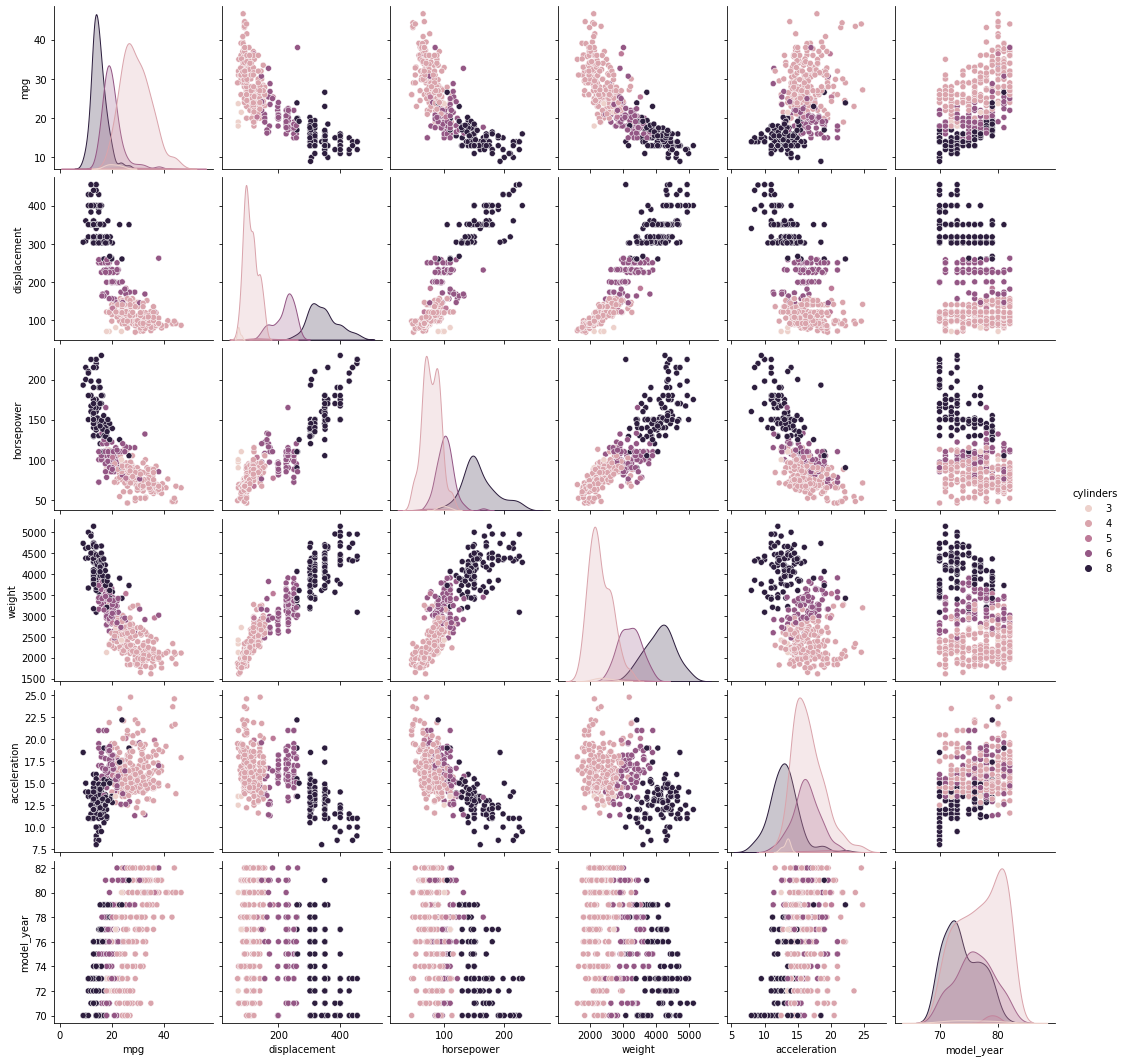

In [23]:
sns.pairplot(mpg, hue = "cylinders")

There seem to be exponential relationships between mpg and displacement, horsepower, and acceleration. Thus, the latter three features will be transformed logarithmically.

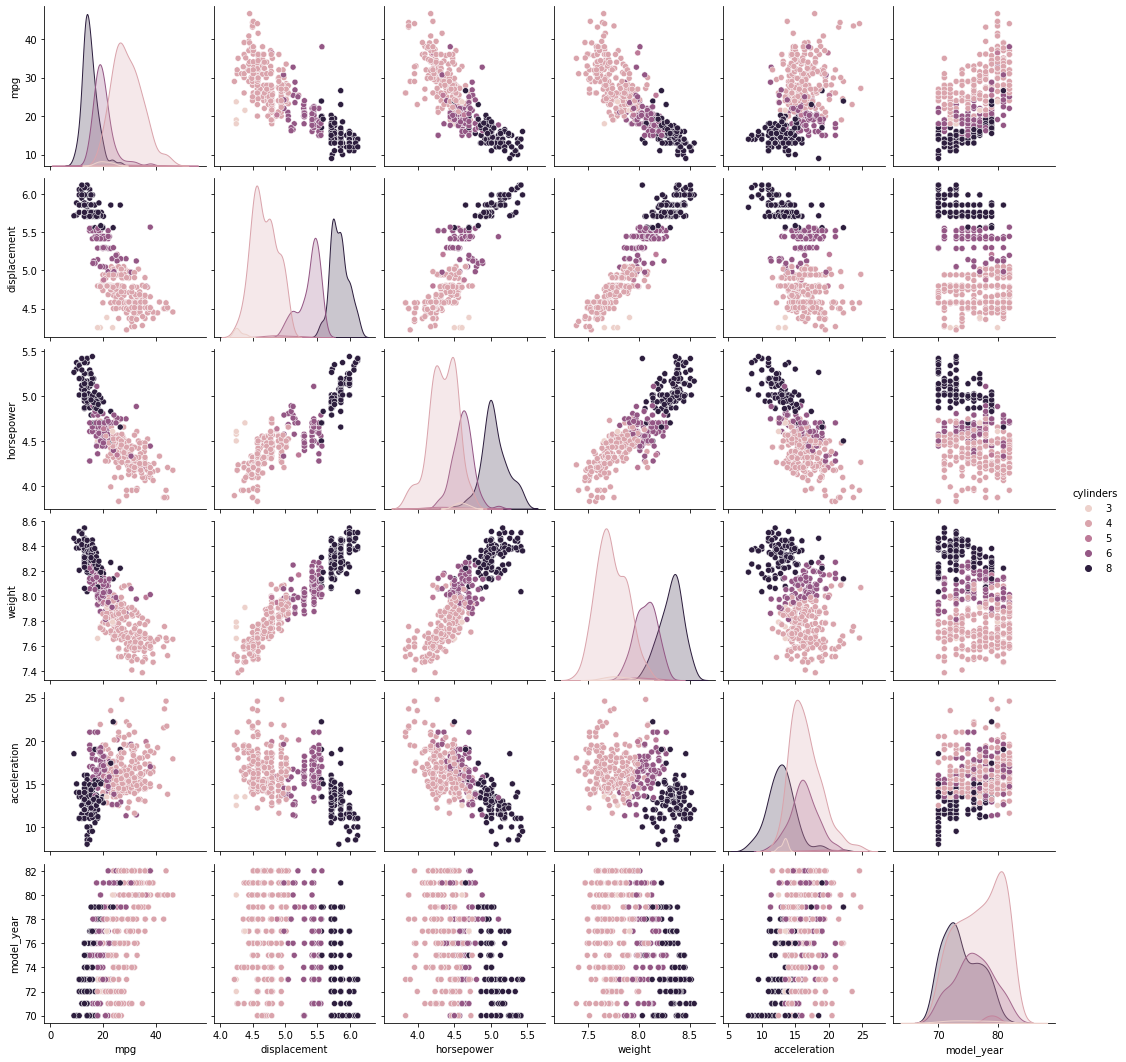

In [24]:
# create copy and apply log transformation
mpg_prep = mpg.copy()
mpg_prep['displacement'] = np.log(mpg_prep['displacement'])
mpg_prep['horsepower'] = np.log(mpg_prep['horsepower'])
mpg_prep['weight'] = np.log(mpg_prep['weight'])
sns.pairplot(mpg_prep, hue = "cylinders")

In [25]:
mpg.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316
model_year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000


In [26]:
mpg_prep.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
mpg,1.000000,-0.777618,-0.828453,-0.817517,-0.844194,0.423329,0.580541
cylinders,-0.777618,1.000000,0.942814,0.843204,0.884303,-0.504683,-0.345647
displacement,-0.828453,0.942814,1.000000,0.872149,0.942850,-0.497107,-0.329777
horsepower,-0.817517,0.843204,0.872149,1.000000,0.873956,-0.698328,-0.397078
weight,-0.844194,0.884303,0.942850,0.873956,1.000000,-0.401563,-0.287088
acceleration,0.423329,-0.504683,-0.497107,-0.698328,-0.401563,1.000000,0.290316
model_year,0.580541,-0.345647,-0.329777,-0.397078,-0.287088,0.290316,1.000000


From a first analysis, cylinders, displacement, horsepower, weight, acceleration, and model year could be features to explain miles per gallon.

In [27]:
# split the data
train, test = train_test_split(mpg_prep, test_size=0.2, random_state=142)
train.shape, test.shape

((313, 9), (79, 9))

In [38]:
# linear model with weight as predictor
feature_cols = ["weight"]
X_train = train[feature_cols]
y_train = train["mpg"]

model = linear_model.LinearRegression()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
print("y = x *", model.coef_, "+", model.intercept_)
print("MSE:", mean_squared_error(y_train, pred_train))
print("R^2:", r2_score(y_train, pred_train))
print(pred_train[:5])

y = x * [-23.66518534] + 211.65175235093247
MSE: 16.200727846826
R^2: 0.7263427115299346
[11.98699457 24.9373743  12.77425584 10.31908018 22.45729695]


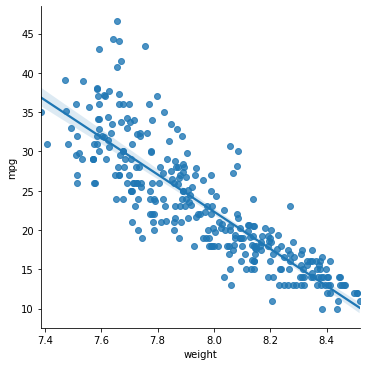

In [35]:
sns.lmplot(data = train, x = "weight", y = "mpg")

In [40]:
# evaluate the model on test data
X_test = test[feature_cols]
y_test = test['mpg']
pred_test = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, pred_test))
print("R^2:", r2_score(y_test, pred_test))

MSE: 22.57859597200402
R^2: 0.6583711188428064


From the training data, the model does moderately well but there seems to be room for improvement. Additionally, it did worse on the test data which indicates underfitting. More features will be included in the following.

In [45]:
# create second model adding horsepower
feature_cols = ["weight", "horsepower"]
X_train = train[feature_cols]
y_train = train["mpg"]

model2 = linear_model.LinearRegression()
model2.fit(X_train, y_train)
pred_train2 = model2.predict(X_train)
print("y = x *", model2.coef_, "+", model2.intercept_)
print("MSE:", mean_squared_error(y_train, pred_train2))
print("R^2:", r2_score(y_train, pred_train2))
print(pred_train2[:5])

y = x * [-16.3108378   -6.90502862] + 184.787679988051
MSE: 14.880885213050298
R^2: 0.7486370528571368
[10.087637   25.83986212 12.05165814  9.50682867 23.71189505]


In [46]:
# evaluate the model on test data
X_test = test[feature_cols]
y_test = test['mpg']
pred_test2 = model2.predict(X_test)
print("MSE:", mean_squared_error(y_test, pred_test2))
print("R^2:", r2_score(y_test, pred_test2))

MSE: 19.79176005328739
R^2: 0.7005377636625436


Again, the results are not satisfying.

In [47]:
# create third model adding cylinders
feature_cols = ["weight", "horsepower", "cylinders"]
X_train = train[feature_cols]
y_train = train["mpg"]

model3 = linear_model.LinearRegression()
model3.fit(X_train, y_train)
pred_train3 = model3.predict(X_train)
print("y = x *", model3.coef_, "+", model3.intercept_)
print("MSE:", mean_squared_error(y_train, pred_train3))
print("R^2:", r2_score(y_train, pred_train3))
print(pred_train3[:5])

y = x * [-14.54466146  -6.24110221  -0.46041712] + 170.20024845079945
MSE: 14.75589309817885
R^2: 0.7507483779506301
[10.087637   25.83986212 12.05165814  9.50682867 23.71189505]


In [48]:
# evaluate the model on test data
X_test = test[feature_cols]
y_test = test['mpg']
pred_test3 = model3.predict(X_test)
print("MSE:", mean_squared_error(y_test, pred_test3))
print("R^2:", r2_score(y_test, pred_test3))

MSE: 20.443843682559603
R^2: 0.6906713131106399


In [49]:
# create fourth model adding displacement
feature_cols = ["weight", "horsepower", "cylinders", "displacement"]
X_train = train[feature_cols]
y_train = train["mpg"]

model4 = linear_model.LinearRegression()
model4.fit(X_train, y_train)
pred_train4 = model4.predict(X_train)
print("y = x *", model4.coef_, "+", model4.intercept_)
print("MSE:", mean_squared_error(y_train, pred_train4))
print("R^2:", r2_score(y_train, pred_train4))
print(pred_train4[:5])

y = x * [-9.88778142 -5.50102528  0.34570601 -5.49910113] + 153.56078521040874
MSE: 14.291500447202782
R^2: 0.7585927436392021
[10.99026057 26.45248114 11.87220309  9.7822147  23.01072451]


In [50]:
# evaluate the model on test data
X_test = test[feature_cols]
y_test = test['mpg']
pred_test4 = model4.predict(X_test)
print("MSE:", mean_squared_error(y_test, pred_test4))
print("R^2:", r2_score(y_test, pred_test4))

MSE: 21.81021454552663
R^2: 0.6699972309072999


In [51]:
# create fifth model adding model year
feature_cols = ["weight", "horsepower", "cylinders", "displacement", "model_year"]
X_train = train[feature_cols]
y_train = train["mpg"]

model5 = linear_model.LinearRegression()
model5.fit(X_train, y_train)
pred_train5 = model5.predict(X_train)
print("y = x *", model5.coef_, "+", model5.intercept_)
print("MSE:", mean_squared_error(y_train, pred_train5))
print("R^2:", r2_score(y_train, pred_train5))
print(pred_train5[:5])

y = x * [-14.55457529  -2.0319248    0.61663651  -4.28212372   0.70207022] + 113.70338405406511
MSE: 8.958919091692858
R^2: 0.8486689283694316
[ 8.86570396 27.36018077 10.01906516  9.36260189 24.09101835]


In [52]:
# evaluate the model on test data
X_test = test[feature_cols]
y_test = test['mpg']
pred_test5 = model5.predict(X_test)
print("MSE:", mean_squared_error(y_test, pred_test5))
print("R^2:", r2_score(y_test, pred_test5))

MSE: 12.450545090010285
R^2: 0.8116151334577482


In [53]:
# create sixth model adding acceleration
feature_cols = ["weight", "horsepower", "cylinders", "displacement", "model_year", "acceleration"]
X_train = train[feature_cols]
y_train = train["mpg"]

model6 = linear_model.LinearRegression()
model6.fit(X_train, y_train)
pred_train6 = model6.predict(X_train)
print("y = x *", model6.coef_, "+", model6.intercept_)
print("MSE:", mean_squared_error(y_train, pred_train6))
print("R^2:", r2_score(y_train, pred_train6))
print(pred_train6[:5])

y = x * [-12.51348153  -3.98531919   0.61734411  -4.69678551   0.69349235
  -0.17172678] + 111.87224075183639
MSE: 8.893696134716283
R^2: 0.8497706527932332
[ 8.32472455 27.83374801 10.18934578  9.45725237 24.32429845]


In [54]:
# evaluate the model on test data
X_test = test[feature_cols]
y_test = test['mpg']
pred_test6 = model6.predict(X_test)
print("MSE:", mean_squared_error(y_test, pred_test6))
print("R^2:", r2_score(y_test, pred_test6))

MSE: 12.25089518004323
R^2: 0.8146359667925467


**This is your final checkpoint for this week**

**You have to report MSE and $R^2$ values on the training and test set. Also, provide your interpretation of results. Based on the values on training and testing data, comment whether model is overfitting?**

Model number 5 and 6 can both be considered good models. They both achieve a high R^2 and a lower MSE compared to the other models. Also, the model seems to fit the data well since there is no significant difference between the training and test data.

## Commit your finished work on Github
Here are the list of steps you need to follow to commit your work on Github to get checkpoint mark for this week.

Once you finished all the above questions, save the notebook by clicking 'save' button in the toolbar.

You need to follow the same instructions to commit your work on your Github repository.

Step 1. Change your current directory to `practical-workshops-yourName` by doing `cd` command. You can type:
                    `cd practical-workshops-yourName`
                    
Step 2: Add your Workshop Week 5.ipynb using:
                 `git add "Workshop Week 5.ipynb`
                 
Step 3: Commit your work:
                `git commit -m "Finished Workshop 5`
                
Step 4: Push your changes:
                `git push origin master`
                
Step 5: Confirm whether your finished work is now on Github repository by signing into your Github account and clicking on your repository. You can see your added `Workshop Week 5.ipynb` file as well as your `commit message` and `time` of your commit.

Step 6: Well done!. You have now finished your Practical Workshop Week 5. Appreciate yourself.